In [1]:
# Test the custom Nifti Dataset
import os
import torch
from omegaconf import OmegaConf

from wdm.configuration.files import LMDBDatasetConfig
from wdm.utils.transforms import Cropper, Resize3D
from wdm.datasets.file_based import LMDBDataset
from wdm.datasets.utils import instantiate_datasets
from wdm.utils.masking import DirectorySampler
from wdm.configuration.mask import PresampledMaskConfig
from wdm.datasets.mri import MRIMaskedDataset
from wdm.dataloaders.inpainting import MRIInpaintDataLoader
from wdm.utils.logging_tools import Session

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

In [ ]:
# Config load
CONFIG_FILE = "train/wdm.yaml"

config = OmegaConf.load(CONFIG_FILE)

datasets = instantiate_datasets(config.datasets)

Selected datasets:
-- IXI Dataset (Location: ../test_data/IXI/lmdb/volumes_T1w)
-- IXI Dataset (Location: ../test_data/IXI/lmdb/volumes_T1w)
-- IXI Dataset (Location: ../test_data/IXI/lmdb/volumes_T1w)


In [4]:
dataset_configuration = LMDBDatasetConfig(
    lmdb_folder="../test_data/IXI/lmdb",
    is_volume=True,
    modality="T1w",
    mtransforms=[Cropper((192, 160))]
)
dataset_configuration

In [5]:
lmbd_dataset = LMDBDataset(dataset_configuration)

In [6]:
mask_sampler = DirectorySampler(PresampledMaskConfig("../masks"))

In [7]:
img_shape = (config.model_config.image_size,)*3
img_shape

(64, 64, 64)

In [8]:
from wdm.utils.transforms import MaskTransform

tfs = {"img": [Resize3D(img_shape, "trilinear")], "mask": [Resize3D(img_shape, "trilinear"), MaskTransform()]}

In [9]:
a = MRIMaskedDataset(lmbd_dataset, age_range=None, mask_sampler=mask_sampler)
next(iter(a))

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
       

In [10]:
mri_dataloader = MRIInpaintDataLoader(lmbd_dataset, age_range=None, mask_sampler=mask_sampler, batch_size=1, num_workers=0, transforms=tfs)
mri_dataloader.setup()
train_mri_dataloader = mri_dataloader.train_dataloader() 

In [11]:
img : torch.Tensor
mask : torch.Tensor
cond : torch.Tensor
img, mask, cond = next(iter(train_mri_dataloader))
batch = (img, mask, cond)

In [12]:
img.shape, mask.shape, cond.shape

(torch.Size([1, 1, 64, 64, 64]),
 torch.Size([1, 1, 64, 64, 64]),
 torch.Size([1, 2]))

In [13]:
batch = tuple(b.to(device) for b in batch)

In [14]:
import matplotlib.pyplot as plt

def show_image(img, slice=65):
    # Visualize the mask
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img[:,slice,...].cpu(), cmap="gray")
    plt.axis("off")
    plt.show()

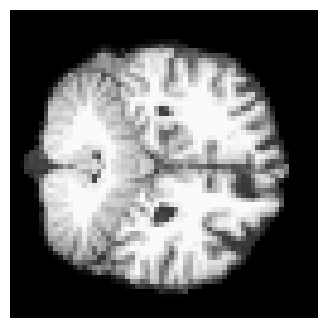

In [15]:
show_image(img[0, 0], slice = 20)

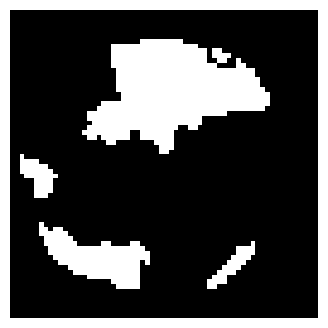

In [ ]:
show_image(mask[0, 0], slice = 20)

In [17]:
from wdm.model.wdm import WDM
from wdm.model.diffusion.sampler import create_named_schedule_sampler
from wdm.model.utils.etc import create_model_and_diffusion, model_and_diffusion_defaults

In [18]:
DIFFUSION_CONFIG = config.diffusion_config
MODEL_CONFIG = config.model_config
COMMON_CONFIG = config.common_config

In [19]:
args = model_and_diffusion_defaults(DIFFUSION_CONFIG, MODEL_CONFIG, COMMON_CONFIG)

In [20]:
args

{'learn_sigma': False,
 'diffusion_steps': 1000,
 'noise_schedule': 'linear',
 'timestep_respacing': '',
 'use_kl': False,
 'predict_xstart': False,
 'rescale_timesteps': False,
 'rescale_learned_sigmas': False,
 'dims': 3,
 'num_groups': 32,
 'in_channels': 16,
 'image_size': 64,
 'num_channels': 64,
 'num_res_blocks': 2,
 'num_heads': 1,
 'num_heads_upsample': -1,
 'num_head_channels': -1,
 'attention_resolutions': '16,8',
 'channel_mult': '1,2,2,4,4,4',
 'dropout': 0.0,
 'use_checkpoint': False,
 'use_scale_shift_norm': False,
 'resblock_updown': True,
 'use_new_attention_order': False,
 'out_channels': 8,
 'bottleneck_attention': False,
 'resample_2d': False,
 'additive_skips': True,
 'use_conditional_model': True}

In [21]:
model, diffusion = create_model_and_diffusion(**args)

In [22]:
model = model.to(device)

In [23]:
sampler = create_named_schedule_sampler("uniform", diffusion,  maxt=args["diffusion_steps"])

In [24]:
session = Session("WDM", config)

In [25]:
wdm = WDM(
        model=model,
        session=session,
        diffusion=diffusion,
        batch_size=config.train_config.batch_size,
        in_channels=1,
        microbatch=-1,
        lr=config.train_config.lr,
        log_interval=10,
        img_log_interval=50,
        val_interval=2000,
        schedule_sampler=sampler,
        weight_decay=config.train_config.weight_decay,
        mask_weight=config.train_config.mask_weight,
        clip_denoised=config.sampling_config.clip_denoised,
        steps_scheduler=config.sampling_config.steps_scheduler,
        sampling_steps=config.sampling_config.sampling_steps
    )

Logging to ../wdm_training/WDM_exec_1737967597.301167/logs


In [26]:
wdm.configure_optimizers()

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0
)

In [27]:
batch

(tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           ...,
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]

In [28]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from wdm.utils.logging_tools import AdvancedWandLogger

wand_logger = AdvancedWandLogger(model, session)

In [31]:
# wdm: WDM = WDM.load_from_checkpoint("/mnt/d/Programmazione/Progetti/phd/wdm_training/wdm_training_exec_1737911635.648742/checkpoints/holdout_epoch=01-loss/MSE=0.0202.ckpt",
#                                model = model)
wdm = WDM(
        model=model,
        session=session,
        diffusion=diffusion,
        batch_size=config.train_config.batch_size,
        in_channels=1,
        microbatch=-1,
        lr=config.train_config.lr,
        log_interval=10,
        img_log_interval=50,
        val_interval=2,
        schedule_sampler=sampler,
        weight_decay=config.train_config.weight_decay,
        mask_weight=config.train_config.mask_weight,
        clip_denoised=config.sampling_config.clip_denoised,
        steps_scheduler=config.sampling_config.steps_scheduler,
        sampling_steps=config.sampling_config.sampling_steps
    )

Logging to ../wdm_training/WDM_exec_1737967597.301167/logs


In [32]:
torch.set_default_device('cuda')

In [33]:
def show_image_idwt(img):
    # Visualize the mask
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img[0,0,:,:,img.size()[2]//2].detach().cpu(), cmap="gray")
    plt.axis("off")
    plt.show()

In [34]:
model = wdm.model
diffusion = wdm.diffusion

In [33]:
from wdm.model.DWT.DWT_IDWT_layer import IDWT_3D, DWT_3D
from wdm.model.DWT.utils import convert_to_dwt, convert_to_idwt

dwt, idwt = DWT_3D('haar'), IDWT_3D('haar')

In [34]:
img, mask, cond = img[[0]].to(device), mask[[0]].to(device), cond[[0]].to(device)

In [35]:
x_start_masked = img * (1-mask)
noise = wdm.noise_generator(x_start_masked)
noise = noise * mask

t, weights = wdm.schedule_sampler.sample(img.shape[0], device)

x_t = diffusion.q_sample(x_start_masked, t, noise=noise)

x_t_dwt = convert_to_dwt(x_t, dwt)
mask_cond_dwt = convert_to_dwt(mask, dwt)

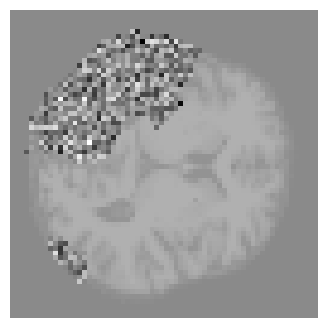

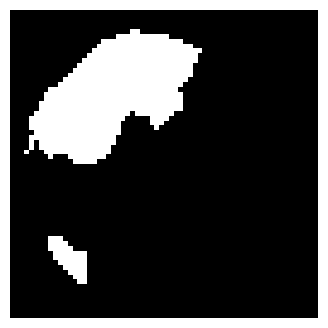

In [37]:
show_image_idwt(x_t)
show_image_idwt(mask)

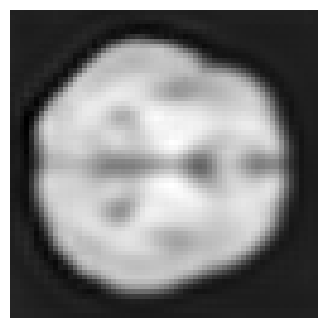

In [39]:
t = torch.tensor([999] * img.shape[0], device=device)

model_output = model(x_t_dwt, diffusion._scale_timesteps(t), label_cond_dwt=mask_cond_dwt)
# Inverse wavelet transform the model output
model_output_idwt = convert_to_idwt(model_output, idwt)
show_image_idwt(model_output_idwt)

In [42]:
noisy_img = x_start_masked + noise

# Let's take the entire volume, and add noise only in the label_cond region
img_dwt = convert_to_dwt(noisy_img, dwt)
mask_dwt = convert_to_dwt(mask, dwt)

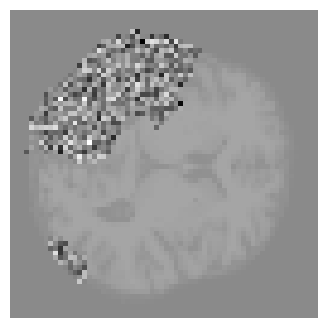

In [43]:
show_image_idwt(noisy_img)

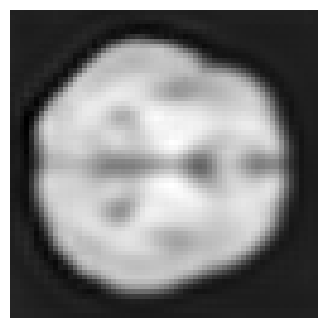

In [45]:
model_output_noisy = model(img_dwt, diffusion._scale_timesteps(t), label_cond_dwt=mask_cond_dwt)
# Inverse wavelet transform the model output
model_output_idwt_noisy = convert_to_idwt(model_output_noisy, idwt)
show_image_idwt(model_output_idwt)

In [51]:
from wdm.model.diffusion.gaussian import ModelVarType, _extract_into_tensor
import numpy as np

model_variance, model_log_variance = {
    # for fixedlarge, we set the initial (log-)variance like so
    # to get a better decoder log likelihood.
    ModelVarType.FIXED_LARGE: (
        np.append(diffusion.posterior_variance[1], diffusion.betas[1:]),
        np.log(np.append(diffusion.posterior_variance[1], diffusion.betas[1:])),
    ),
    ModelVarType.FIXED_SMALL: (
        diffusion.posterior_variance,
        diffusion.posterior_log_variance_clipped,
    ),
}[diffusion.model_var_type]

model_varianc_dwt, model_log_variance_dwt = _extract_into_tensor(model_variance, t, img_dwt.shape), _extract_into_tensor(model_log_variance, t, img_dwt.shape)

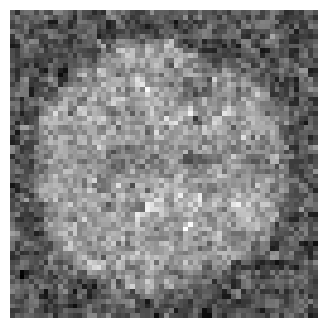

In [50]:
sample_dwt = model_output_noisy + torch.exp(0.5 * model_log_variance) * wdm.noise_generator(model_output_noisy)
sample_idwt = convert_to_idwt(sample_dwt, idwt)
show_image_idwt(sample_idwt)

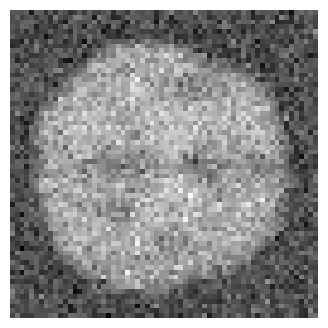

In [53]:
sample_dwt = model_output_noisy 
sample_idwt = convert_to_idwt(sample_dwt, idwt)
sample_idwt = sample_idwt + torch.exp(0.5 * _extract_into_tensor(model_log_variance, t, sample_idwt.shape)) * wdm.noise_generator(sample_idwt)
show_image_idwt(sample_idwt)

In [31]:
# wdm.training_step((img.to(device), mask.to(device), cond), 0)

In [35]:
wdm.sampling_steps = 1000
wdm.sample_model(img.to(device), mask.to(device), cond, wdm.noise_generator)

steps_scheduler: None
time: 1000
Using Default time scheduler (linear, constant steps)
Using time: 1000


UnboundLocalError: cannot access local variable 'brain_masked' where it is not associated with a value